# NB 10.1 — $S_t$ Structural Validation

**Question**: Is $S_t$ the best local estimator of basin contraction caused by the mechanism?

**Causal hierarchy**: $p_t \to$ basin contraction $\to S_t$

---

| Test | Question | PASS criterion |
|------|----------|----------------|
| **Test 1** — Basin vs No-Basin | Does $S_t$ discriminate contracting vs intact basins? | S drops for contracting, flat for non-contracting |
| **Test 2** — $S_t$ vs EWS | Does $S_t$ add info beyond classical early-warning signals? | $\rho_{partial}(S_t, \tau \mid \text{all EWS}) > 0.10$ in ≥ 2/3 systems |
| **Test 3** — Monotonicity | Does $S_t$ track theoretical basin width? | $\rho(S_t, W_t) > 0.80$ in ≥ 2/3 systems |

**Overall verdict**: PASS = 3/3, PARTIAL = 2/3, FAIL = ≤1/3

In [1]:
# ============================================================
#  IMPORTS + CONSTANTS
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, ttest_1samp
import warnings
warnings.filterwarnings('ignore')

# --- Decision thresholds ---
MIN_PARTIAL_RHO  = 0.10
MIN_MONOTONICITY = 0.80   # ρ(S_t, basin_width) threshold
P_THRESHOLD      = 0.05

# --- Computational ---
N_ROLLOUTS  = 300
HORIZON     = 80
PERTURB_STD = 0.05
N_SEEDS     = 10
EWS_WINDOW  = 30
STEP        = 10

# --- System thresholds ---
THRESH_SN  = -0.5
THRESH_DW  =  0.0
THRESH_ECO =  0.3

print("NB 10.1 — S_t Structural Validation")
print("=" * 55)
print(f"Decision thresholds:")
print(f"  partial ρ min:   {MIN_PARTIAL_RHO}")
print(f"  monotonicity ρ:  {MIN_MONOTONICITY}")
print(f"  significance:    p < {P_THRESHOLD}")
print(f"\nComputational: N={N_ROLLOUTS}, H={HORIZON}, seeds={N_SEEDS}")
print("=" * 55)

NB 10.1 — S_t Structural Validation
Decision thresholds:
  partial ρ min:   0.1
  monotonicity ρ:  0.8
  significance:    p < 0.05

Computational: N=300, H=80, seeds=10


In [8]:
# ============================================================
#  SYSTEM GENERATORS + ROLLOUTS + UTILITIES
# ============================================================

# ── Original 3 systems (from NB 10) ──────────────────────────

def saddle_node(T=300, seed=42):
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r = np.linspace(2.0, -0.5, T)
    x = np.zeros(T); x[0] = np.sqrt(r[0])
    for t in range(1, T):
        x[t] = x[t-1] + dt*(r[t-1] - x[t-1]**2) + rng.normal(0, noise)
        x[t] = max(x[t], -5.0)
    bif_t = np.argmin(np.abs(r))
    return x, r, bif_t

def rollout_sn(x0, r_start, r_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r_vals = np.linspace(r_start, r_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    futures = np.zeros((N, H))
    for h in range(H):
        x = x + dt*(r_vals[h] - x**2) + rng.normal(0, noise, N)
        x = np.clip(x, -5.0, 5.0)
        futures[:, h] = x
    return futures

def double_well(T=400, seed=42):
    rng = np.random.RandomState(seed)
    dt, noise = 0.01, 0.12
    r = np.linspace(-0.3, 0.6, T)
    x = np.zeros(T); x[0] = -0.9
    for t in range(1, T):
        x[t] = x[t-1] + dt*(x[t-1] - x[t-1]**3 + r[t-1]) + rng.normal(0, noise)
        x[t] = np.clip(x[t], -3.0, 3.0)
    bif_r = 2.0 / (3.0*np.sqrt(3.0))
    bif_t = np.argmin(np.abs(r - bif_r))
    return x, r, bif_t

def rollout_dw(x0, r_start, r_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise = 0.01, 0.12
    r_vals = np.linspace(r_start, r_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    futures = np.zeros((N, H))
    for h in range(H):
        x = x + dt*(x - x**3 + r_vals[h]) + rng.normal(0, noise, N)
        x = np.clip(x, -3.0, 3.0)
        futures[:, h] = x
    return futures

def ecosystem_shift(T=400, seed=42):
    rng = np.random.RandomState(seed)
    dt, noise, r_g, K, s = 0.05, 0.02, 1.0, 1.0, 0.2
    h = np.linspace(0.05, 0.35, T)
    x = np.zeros(T); x[0] = 0.8
    for t in range(1, T):
        grazing = h[t-1]*x[t-1]**2 / (x[t-1]**2 + s**2)
        growth  = r_g*x[t-1]*(1.0 - x[t-1]/K)
        x[t] = x[t-1] + dt*(growth - grazing) + rng.normal(0, noise)
        x[t] = max(x[t], 0.01)
    bif_t = T
    for t in range(50, T):
        if x[t] < 0.3:
            bif_t = t; break
    return x, h, bif_t

def rollout_eco(x0, h_start, h_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise, r_g, K, s = 0.05, 0.02, 1.0, 1.0, 0.2
    h_vals = np.linspace(h_start, h_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    x = np.clip(x, 0.01, 3.0)
    futures = np.zeros((N, H))
    for h_step in range(H):
        grazing = h_vals[h_step]*x**2 / (x**2 + s**2)
        growth  = r_g*x*(1.0 - x/K)
        x = x + dt*(growth - grazing) + rng.normal(0, noise, N)
        x = np.clip(x, 0.01, 3.0)
        futures[:, h_step] = x
    return futures

# ── NEW systems for Test 1 ───────────────────────────────────

def saddle_node_safe(T=300, seed=42):
    """SN with r: 2.0 → 1.5 — basin stays wide, no bifurcation."""
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r = np.linspace(2.0, 1.5, T)
    x = np.zeros(T); x[0] = np.sqrt(r[0])
    for t in range(1, T):
        x[t] = x[t-1] + dt*(r[t-1] - x[t-1]**2) + rng.normal(0, noise)
        x[t] = max(x[t], -5.0)
    return x, r, T   # bif_t = T (never)

def linear_system(T=300, seed=42):
    """dx/dt = -(x - r(t)): single global attractor, no bifurcation."""
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r = np.linspace(0.5, 2.0, T)
    x = np.zeros(T); x[0] = 0.5
    for t in range(1, T):
        x[t] = x[t-1] + dt*(-(x[t-1] - r[t-1])) + rng.normal(0, noise)
    return x, r, T   # bif_t = T (never)

def rollout_linear(x0, r_start, r_end, N, H, eps=0.05, seed=0):
    rng = np.random.RandomState(seed)
    dt, noise = 0.02, 0.08
    r_vals = np.linspace(r_start, r_end, H)
    x = np.full(N, float(x0)) + rng.normal(0, eps, N)
    futures = np.zeros((N, H))
    for h in range(H):
        x = x + dt*(-(x - r_vals[h])) + rng.normal(0, noise, N)
        futures[:, h] = x
    return futures

# ── Core S_t computation ─────────────────────────────────────

def compute_survival_timeseries(
    trajectory, param_schedule, rollout_fn, threshold,
    n_rollouts=N_ROLLOUTS, horizon=HORIZON, perturb_std=PERTURB_STD,
    step=STEP, survival_direction='above'
):
    T = len(trajectory)
    times = np.arange(0, T, step)
    survival = np.zeros(len(times))
    for i, t in enumerate(times):
        x0 = trajectory[t]
        p_start = param_schedule[t]
        p_end = param_schedule[min(t + horizon, T - 1)]
        futures = rollout_fn(x0, p_start, p_end, n_rollouts, horizon,
                            eps=perturb_std, seed=i)
        endpoints = futures[:, -1]
        if survival_direction == 'above':
            survival[i] = np.mean(endpoints > threshold)
        else:
            survival[i] = np.mean(endpoints < threshold)
    return times, survival

# ── Partial correlation (1 and N controls) ────────────────────

def partial_corr(x, y, z):
    """ρ(x, y | z) via OLS residuals + Spearman."""
    cx = np.polyfit(z, x, 1); rx = x - np.polyval(cx, z)
    cy = np.polyfit(z, y, 1); ry = y - np.polyval(cy, z)
    return spearmanr(rx, ry)

def partial_corr_multi(x, y, Z):
    """ρ(x, y | Z_1,...,Z_k) via multivariate OLS residuals + Spearman."""
    if Z.ndim == 1:
        Z = Z.reshape(-1, 1)
    Z_aug = np.column_stack([Z, np.ones(len(x))])
    cx, _, _, _ = np.linalg.lstsq(Z_aug, x, rcond=None)
    rx = x - Z_aug @ cx
    cy, _, _, _ = np.linalg.lstsq(Z_aug, y, rcond=None)
    ry = y - Z_aug @ cy
    return spearmanr(rx, ry)

# ── Early Warning Signals ────────────────────────────────────

def ews_at_times(traj, times, window=EWS_WINDOW):
    """Compute rolling variance, AC(1), skewness at specified time points."""
    n = len(times)
    var_arr  = np.full(n, np.nan)
    ac1_arr  = np.full(n, np.nan)
    skew_arr = np.full(n, np.nan)
    for i, t in enumerate(times.astype(int)):
        if t < window:
            continue
        seg = traj[t - window : t]
        var_arr[i] = np.var(seg)
        std = np.std(seg)
        if std > 1e-10:
            ac1_arr[i] = np.corrcoef(seg[:-1], seg[1:])[0, 1]
            skew_arr[i] = np.mean(((seg - seg.mean()) / std) ** 3)
    return var_arr, ac1_arr, skew_arr

# ── Theoretical basin widths ─────────────────────────────────

def sn_basin_width(r_val):
    """Saddle-node: basin = 2√r for r>0, else 0."""
    return 2.0 * np.sqrt(max(r_val, 0.0))

def dw_basin_width(r_val):
    """Double-well: basin of left well = x_unstable - x_stable_left."""
    coeffs = [1, 0, -1, -r_val]
    roots = np.roots(coeffs)
    real_roots = sorted([rt.real for rt in roots if abs(rt.imag) < 1e-8])
    if len(real_roots) == 3:
        return real_roots[1] - real_roots[0]  # unstable - left stable
    return 0.0

def eco_basin_width(h_val, r_g=1.0, K=1.0, s=0.2):
    """Ecosystem: resilience = equilibrium position (basin margin proxy).
    
    This model has a single positive equilibrium that slides toward 0
    as h increases — no fold bifurcation with these parameters.
    W(h) = x_eq(h) captures how far the system is from collapse.
    """
    # Non-trivial equilibria: x³ - x² + (s²+h)x - s² = 0
    coeffs = [1, -1, s**2 + h_val, -s**2]
    roots = np.roots(coeffs)
    real_pos = sorted([rt.real for rt in roots
                       if abs(rt.imag) < 1e-8 and rt.real > 0.01])
    if len(real_pos) >= 2:
        return real_pos[-1] - real_pos[-2]  # upper - unstable
    elif len(real_pos) == 1:
        return real_pos[0]  # equilibrium position as resilience proxy
    return 0.0

# ── Systems registry ─────────────────────────────────────────
SYSTEMS = [
    {"name": "Saddle-Node", "gen": saddle_node, "roll": rollout_sn,
     "thresh": THRESH_SN, "surv_dir": "above", "basin_fn": sn_basin_width},
    {"name": "Double-Well", "gen": double_well, "roll": rollout_dw,
     "thresh": THRESH_DW, "surv_dir": "below", "basin_fn": dw_basin_width},
    {"name": "Ecosystem",   "gen": ecosystem_shift, "roll": rollout_eco,

     "thresh": THRESH_ECO, "surv_dir": "above", "basin_fn": eco_basin_width},
]

print("✓ 3 original systems + 2 control systems defined")
print("✓ EWS functions (var, AC1, skewness)")
print("✓ Theoretical basin-width functions (SN analytic, DW/ECO resilience)")
print("✓ Partial correlation (single + multi-control)")
print("✓ 3 original systems + 2 control systems defined")

✓ 3 original systems + 2 control systems defined
✓ EWS functions (var, AC1, skewness)
✓ Theoretical basin-width functions (SN analytic, DW/ECO resilience)
✓ Partial correlation (single + multi-control)
✓ 3 original systems + 2 control systems defined


---

## Test 1 — Structural Discrimination: Basin vs No-Basin

**Logic**: If $S_t$ measures basin geometry (not just $p_t$), then:
- **SN-contracting** ($r: 2 \to -0.5$, basin vanishes): $S_t$ must **drop**
- **SN-safe** ($r: 2 \to 1.5$, basin intact): $S_t$ must stay **flat**
- **Linear** (no bifurcation, infinite basin): $S_t$ must stay **flat**

Same dynamics, same noise, only the parameter range differs. If $S_t$ tracked $p_t$ blindly, it would drop in all 3. If it tracks basin geometry, it only drops when the basin actually contracts.

**PASS**: contracting range > 0.3 AND both non-contracting range < 0.15

  TEST 1 — STRUCTURAL DISCRIMINATION


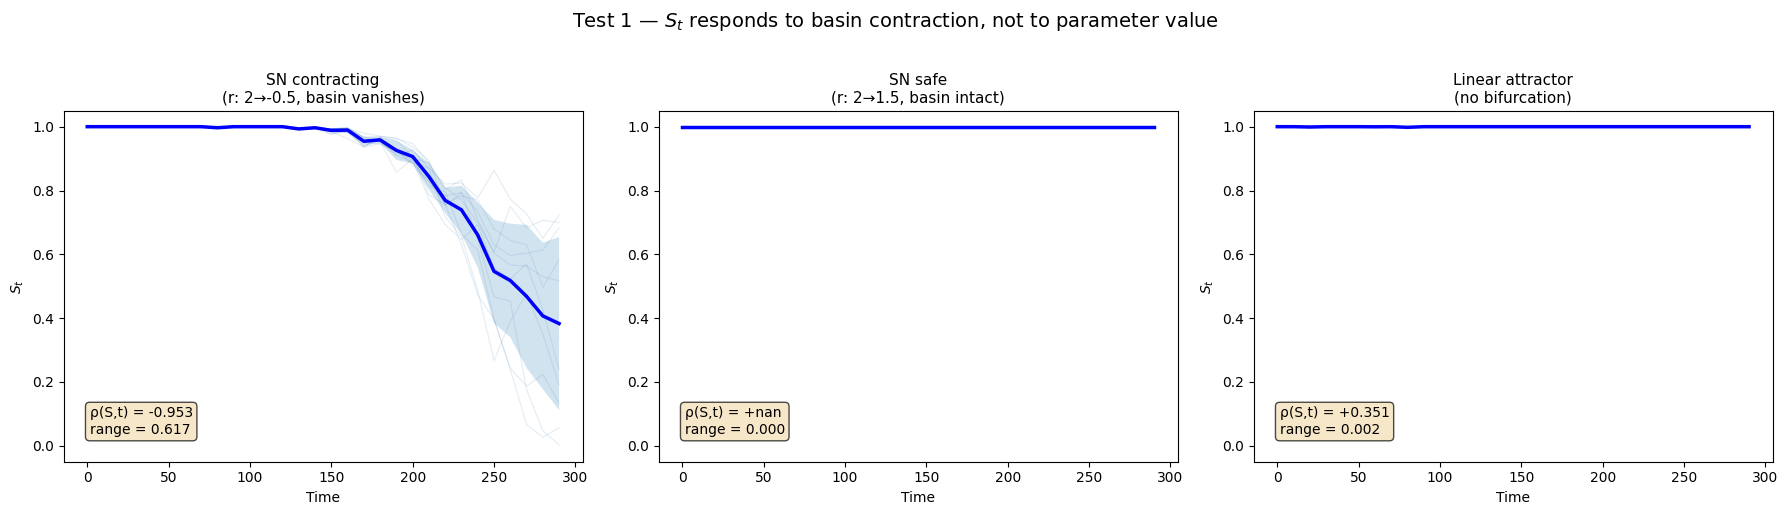


TEST 1 SUMMARY
  SN-contracting: range = 0.617  (> 0.30? ★)
  SN-safe:        range = 0.000  (< 0.15? ★)
  Linear:         range = 0.002  (< 0.15? ★)

  Test 1 verdict: PASS


In [3]:
# ============================================================
#  TEST 1 — BASIN vs NO-BASIN
# ============================================================

print("="*70)
print("  TEST 1 — STRUCTURAL DISCRIMINATION")
print("="*70)

test1_configs = [
    {"name": "SN-contracting", "gen": saddle_node,      "roll": rollout_sn,
     "thresh": THRESH_SN, "surv_dir": "above",
     "label": "SN contracting\n(r: 2→-0.5, basin vanishes)"},
    {"name": "SN-safe",        "gen": saddle_node_safe,  "roll": rollout_sn,
     "thresh": THRESH_SN, "surv_dir": "above",
     "label": "SN safe\n(r: 2→1.5, basin intact)"},
    {"name": "Linear",         "gen": linear_system,     "roll": rollout_linear,
     "thresh": THRESH_SN, "surv_dir": "above",
     "label": "Linear attractor\n(no bifurcation)"},
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
test1_results = {}

for idx, cfg in enumerate(test1_configs):
    ax = axes[idx]
    all_surv = []
    ref_times = None

    for seed in range(N_SEEDS):
        traj, p, bif_t = cfg['gen'](seed=seed)
        times, surv = compute_survival_timeseries(
            traj, p, cfg['roll'], cfg['thresh'],
            n_rollouts=N_ROLLOUTS, horizon=HORIZON,
            perturb_std=PERTURB_STD, step=STEP,
            survival_direction=cfg['surv_dir']
        )
        all_surv.append(surv)
        if ref_times is None:
            ref_times = times

    all_surv = np.array(all_surv)
    mean_s = all_surv.mean(axis=0)
    std_s  = all_surv.std(axis=0)

    # Temporal correlation + range
    rho_t, p_val = spearmanr(mean_s, ref_times)
    s_range = mean_s.max() - mean_s.min()

    test1_results[cfg['name']] = {
        'rho_t': rho_t, 'p_val': p_val,
        's_range': s_range, 'mean_s': mean_s, 'times': ref_times,
    }

    # Plot
    for row in all_surv:
        ax.plot(ref_times, row, color='steelblue', alpha=0.15, lw=0.8)
    ax.plot(ref_times, mean_s, 'b-', lw=2.5, label='mean')
    ax.fill_between(ref_times, mean_s - std_s, mean_s + std_s, alpha=0.2)
    ax.set_title(cfg['label'], fontsize=11)
    ax.set_xlabel("Time")
    ax.set_ylabel("$S_t$")
    ax.set_ylim(-0.05, 1.05)
    ax.text(0.05, 0.08,
            f"ρ(S,t) = {rho_t:+.3f}\nrange = {s_range:.3f}",
            transform=ax.transAxes, fontsize=10,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

plt.suptitle("Test 1 — $S_t$ responds to basin contraction, not to parameter value",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/simulated/test1_basin_discrimination.png",
            dpi=150, bbox_inches='tight')
plt.show()

# ── Verdict ───────────────────────────────────────
contracting_drops = test1_results['SN-contracting']['s_range'] > 0.3
safe_flat   = test1_results['SN-safe']['s_range'] < 0.15
linear_flat = test1_results['Linear']['s_range'] < 0.15

t1_verdict = "PASS" if (contracting_drops and safe_flat and linear_flat) else "FAIL"

print(f"\n{'='*55}")
print(f"TEST 1 SUMMARY")
print(f"{'='*55}")
print(f"  SN-contracting: range = {test1_results['SN-contracting']['s_range']:.3f}  "
      f"(> 0.30? {'★' if contracting_drops else '✗'})")
print(f"  SN-safe:        range = {test1_results['SN-safe']['s_range']:.3f}  "
      f"(< 0.15? {'★' if safe_flat else '✗'})")
print(f"  Linear:         range = {test1_results['Linear']['s_range']:.3f}  "
      f"(< 0.15? {'★' if linear_flat else '✗'})")
print(f"\n  Test 1 verdict: {t1_verdict}")
print(f"{'='*55}")

---

## Test 2 — $S_t$ vs Classical Early Warning Signals

**Logic**: Classical EWS (rolling variance, AC(1), skewness) also detect critical slowing down. If $S_t$ is just a fancy proxy for EWS, then $\rho_{partial}(S_t, \tau \mid \text{all EWS}) \approx 0$.

If instead $S_t$ captures **geometric** basin information beyond temporal statistics, the partial correlation should survive.

**Computed for each system × seed**:
- $\rho(S_t, \tau)$ — raw S_t signal
- $\rho(\text{EWS}_i, \tau)$ — raw EWS signals
- $\rho_{partial}(S_t, \tau \mid \text{var}, \text{AC1}, \text{skew}, x_t)$ — S_t after removing ALL EWS

**PASS**: $\rho_{partial}(S_t, \tau \mid \text{all EWS}) > 0.10$ mean, in ≥ 2/3 systems

In [4]:
# ============================================================
#  TEST 2 — S_t vs EARLY WARNING SIGNALS
# ============================================================

print("="*70)
print("  TEST 2 — S_t vs CLASSICAL EWS")
print("="*70)

test2_results = {}

for sys in SYSTEMS:
    name = sys['name']
    print(f"\n{'─'*55}")
    print(f"  {name}")
    print(f"{'─'*55}")

    rho_raw_list   = []   # ρ(S, τ)
    rho_var_list   = []   # ρ(var, τ)
    rho_ac1_list   = []   # ρ(AC1, τ)
    rho_skew_list  = []   # ρ(skew, τ)
    rho_part_var   = []   # ρ_partial(S, τ | var)
    rho_part_ac1   = []   # ρ_partial(S, τ | AC1)
    rho_part_all   = []   # ρ_partial(S, τ | var, AC1, skew, x)

    for seed in range(N_SEEDS):
        traj, p_sched, bif_t = sys['gen'](seed=seed)
        T = len(traj)
        times, surv = compute_survival_timeseries(
            traj, p_sched, sys['roll'], sys['thresh'],
            n_rollouts=N_ROLLOUTS, horizon=HORIZON,
            perturb_std=PERTURB_STD, step=STEP,
            survival_direction=sys['surv_dir']
        )

        # EWS at same time points
        var_ews, ac1_ews, skew_ews = ews_at_times(traj, times)
        x_obs = traj[times.astype(int)]

        # Collapse index
        if sys['surv_dir'] == 'below':
            col_idx = np.argmax(traj > 0.5) if (traj > 0.5).any() else T
        else:
            col_idx = np.argmax(traj < sys['thresh']) if (traj < sys['thresh']).any() else T

        # Valid mask: pre-collapse AND post-warmup (EWS needs window)
        valid = (times < min(col_idx, T)) & (~np.isnan(var_ews)) & (~np.isnan(ac1_ews))
        if valid.sum() < 10:
            continue

        t_v = times[valid]
        s_v = surv[valid]
        tau  = bif_t - t_v
        v_v  = var_ews[valid]
        a_v  = ac1_ews[valid]
        sk_v = skew_ews[valid]
        x_v  = x_obs[valid[: len(x_obs)] if len(valid) > len(x_obs) else valid]

        # Handle any remaining NaN in skew
        sk_v = np.nan_to_num(sk_v, nan=0.0)

        # Ensure matching lengths
        n_min = min(len(s_v), len(v_v), len(a_v), len(sk_v), len(x_v))
        s_v, tau, v_v, a_v, sk_v, x_v = (
            s_v[:n_min], tau[:n_min], v_v[:n_min], a_v[:n_min],
            sk_v[:n_min], x_v[:n_min]
        )

        # Raw correlations
        rho_s, _ = spearmanr(s_v, tau)
        rho_raw_list.append(rho_s)
        rho_var_list.append(spearmanr(v_v, tau)[0])
        rho_ac1_list.append(spearmanr(a_v, tau)[0])
        rho_skew_list.append(spearmanr(sk_v, tau)[0])

        # Partial: S controlling for individual EWS
        if np.std(v_v) > 1e-10:
            rho_part_var.append(partial_corr(s_v, tau, v_v)[0])
        if np.std(a_v) > 1e-10:
            rho_part_ac1.append(partial_corr(s_v, tau, a_v)[0])

        # Partial: S controlling for ALL EWS + x simultaneously
        Z = np.column_stack([v_v, a_v, sk_v, x_v])
        if np.all(Z.std(axis=0) > 1e-10) and len(s_v) > 8:
            rho_all, _ = partial_corr_multi(s_v, tau, Z)
            rho_part_all.append(rho_all)

    # Store results
    mean_partial_all = np.mean(rho_part_all) if rho_part_all else 0
    passes = mean_partial_all > MIN_PARTIAL_RHO

    test2_results[name] = {
        'rho_raw':       np.mean(rho_raw_list),
        'rho_var':       np.mean(rho_var_list),
        'rho_ac1':       np.mean(rho_ac1_list),
        'rho_skew':      np.mean(rho_skew_list),
        'partial_var':   np.mean(rho_part_var) if rho_part_var else 0,
        'partial_ac1':   np.mean(rho_part_ac1) if rho_part_ac1 else 0,
        'partial_all':   mean_partial_all,
        'partial_all_std': np.std(rho_part_all) if rho_part_all else 0,
        'passes': passes,
        'n_valid': len(rho_raw_list),
    }

    r = test2_results[name]
    print(f"  Raw signals:")
    print(f"    ρ(S_t, τ)       = {r['rho_raw']:+.3f}")
    print(f"    ρ(Var, τ)       = {r['rho_var']:+.3f}")
    print(f"    ρ(AC1, τ)       = {r['rho_ac1']:+.3f}")
    print(f"    ρ(Skew, τ)      = {r['rho_skew']:+.3f}")
    print(f"  Partial (S controlling for single EWS):")
    print(f"    ρ_part(S,τ|Var) = {r['partial_var']:+.3f}")
    print(f"    ρ_part(S,τ|AC1) = {r['partial_ac1']:+.3f}")
    print(f"  ★ Partial (S controlling for ALL EWS + x):")
    print(f"    ρ_part(S,τ|all) = {r['partial_all']:+.3f} ± {r['partial_all_std']:.3f}  "
          f"{'★' if passes else '✗'}")

# ── Summary ───────────────────────────────────────
print(f"\n{'='*70}")
print("TEST 2 SUMMARY — S_t vs EWS")
print(f"{'='*70}")
print(f"{'System':<15} {'ρ(S,τ)':<10} {'ρ(Var,τ)':<10} {'ρ(AC1,τ)':<10} "
      f"{'ρ_part(S|all)':<16}")
print("-"*70)

t2_pass_count = 0
for nm in ["Saddle-Node", "Double-Well", "Ecosystem"]:
    r = test2_results[nm]
    star = '★' if r['passes'] else '✗'
    if r['passes']:
        t2_pass_count += 1
    print(f"{nm:<15} {r['rho_raw']:+.3f}     {r['rho_var']:+.3f}     "
          f"{r['rho_ac1']:+.3f}     {r['partial_all']:+.3f}±{r['partial_all_std']:.2f} {star}")

t2_verdict = "PASS" if t2_pass_count >= 2 else "FAIL"
print(f"\nTest 2 verdict: {t2_verdict} ({t2_pass_count}/3)")
print(f"{'='*55}")

  TEST 2 — S_t vs CLASSICAL EWS

───────────────────────────────────────────────────────
  Saddle-Node
───────────────────────────────────────────────────────
  Raw signals:
    ρ(S_t, τ)       = +0.958
    ρ(Var, τ)       = +0.025
    ρ(AC1, τ)       = -0.019
    ρ(Skew, τ)      = -0.114
  Partial (S controlling for single EWS):
    ρ_part(S,τ|Var) = +0.848
    ρ_part(S,τ|AC1) = +0.892
  ★ Partial (S controlling for ALL EWS + x):
    ρ_part(S,τ|all) = +0.477 ± 0.290  ★

───────────────────────────────────────────────────────
  Double-Well
───────────────────────────────────────────────────────
  Raw signals:
    ρ(S_t, τ)       = +0.628
    ρ(Var, τ)       = +0.052
    ρ(AC1, τ)       = +0.073
    ρ(Skew, τ)      = -0.052
  Partial (S controlling for single EWS):
    ρ_part(S,τ|Var) = +0.639
    ρ_part(S,τ|AC1) = +0.626
  ★ Partial (S controlling for ALL EWS + x):
    ρ_part(S,τ|all) = +0.716 ± 0.155  ★

───────────────────────────────────────────────────────
  Ecosystem
─────────────

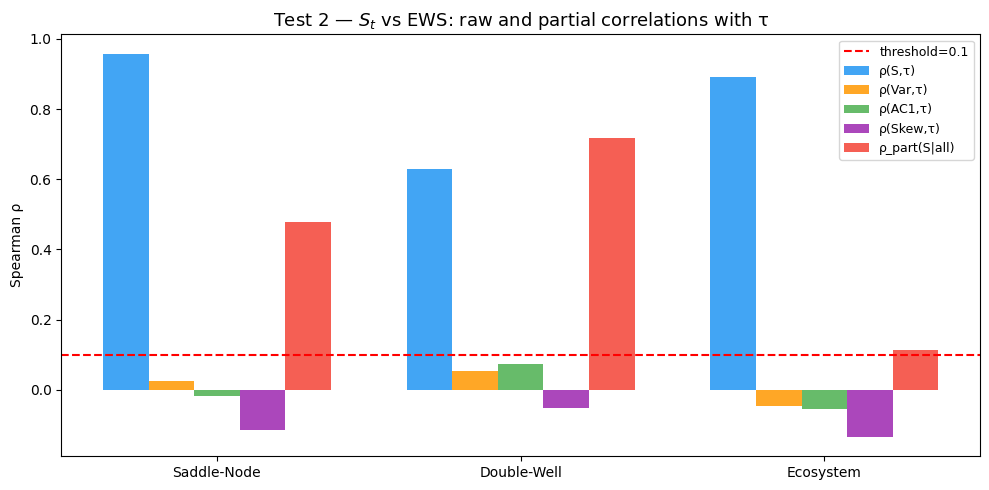

✓ Figure saved


In [5]:
# ── Test 2 Visualization: comparison bar chart ────────────────

fig, ax = plt.subplots(figsize=(10, 5))

sys_names = ["Saddle-Node", "Double-Well", "Ecosystem"]
x_pos = np.arange(len(sys_names))
bar_w = 0.15

# Group bars: raw S_t, Var, AC1, Skew, partial(S|all)
metrics = ['rho_raw', 'rho_var', 'rho_ac1', 'rho_skew', 'partial_all']
labels  = ['ρ(S,τ)', 'ρ(Var,τ)', 'ρ(AC1,τ)', 'ρ(Skew,τ)', 'ρ_part(S|all)']
colors  = ['#2196F3', '#FF9800', '#4CAF50', '#9C27B0', '#F44336']

for j, (metric, label, color) in enumerate(zip(metrics, labels, colors)):
    vals = [test2_results[nm][metric] for nm in sys_names]
    ax.bar(x_pos + j*bar_w, vals, bar_w, label=label, color=color, alpha=0.85)

ax.axhline(y=MIN_PARTIAL_RHO, color='red', ls='--', lw=1.5, label=f'threshold={MIN_PARTIAL_RHO}')
ax.set_xticks(x_pos + 2*bar_w)
ax.set_xticklabels(sys_names)
ax.set_ylabel("Spearman ρ")
ax.set_title("Test 2 — $S_t$ vs EWS: raw and partial correlations with τ", fontsize=13)
ax.legend(loc='upper right', fontsize=9)
plt.tight_layout()
plt.savefig("../results/simulated/test2_st_vs_ews.png", dpi=150, bbox_inches='tight')
plt.show()
print("✓ Figure saved")

---

## Test 3 — Monotonicity: $S_t$ vs Theoretical Basin Width

**Logic**: For each system, the theoretical basin width $W(t)$ can be computed analytically (SN) or semi-analytically (DW, ECO) from the parameter schedule.

If $S_t$ is a faithful estimator of basin geometry, then $\rho(S_t, W_t)$ should be very high.

- **Saddle-node**: $W(r) = 2\sqrt{\max(r, 0)}$ (distance from stable to unstable FP)
- **Double-well**: $W(r) = x_{unstable} - x_{left~stable}$ (cubic roots)
- **Ecosystem**: $W(h) = x_{upper} - x_{unstable}$ (cubic roots)

**PASS**: $\rho(S_t, W_t) > 0.80$ in ≥ 2/3 systems

  TEST 3 — MONOTONICITY

───────────────────────────────────────────────────────
  Saddle-Node
───────────────────────────────────────────────────────
  ρ(S_t, W_t) = +0.904 ± 0.002  (n=10)  ★

───────────────────────────────────────────────────────
  Double-Well
───────────────────────────────────────────────────────
  ρ(S_t, W_t) = +0.658 ± 0.236  (n=10)  ✗

───────────────────────────────────────────────────────
  Ecosystem
───────────────────────────────────────────────────────
  ρ(S_t, W_t) = +0.879 ± 0.017  (n=10)  ★


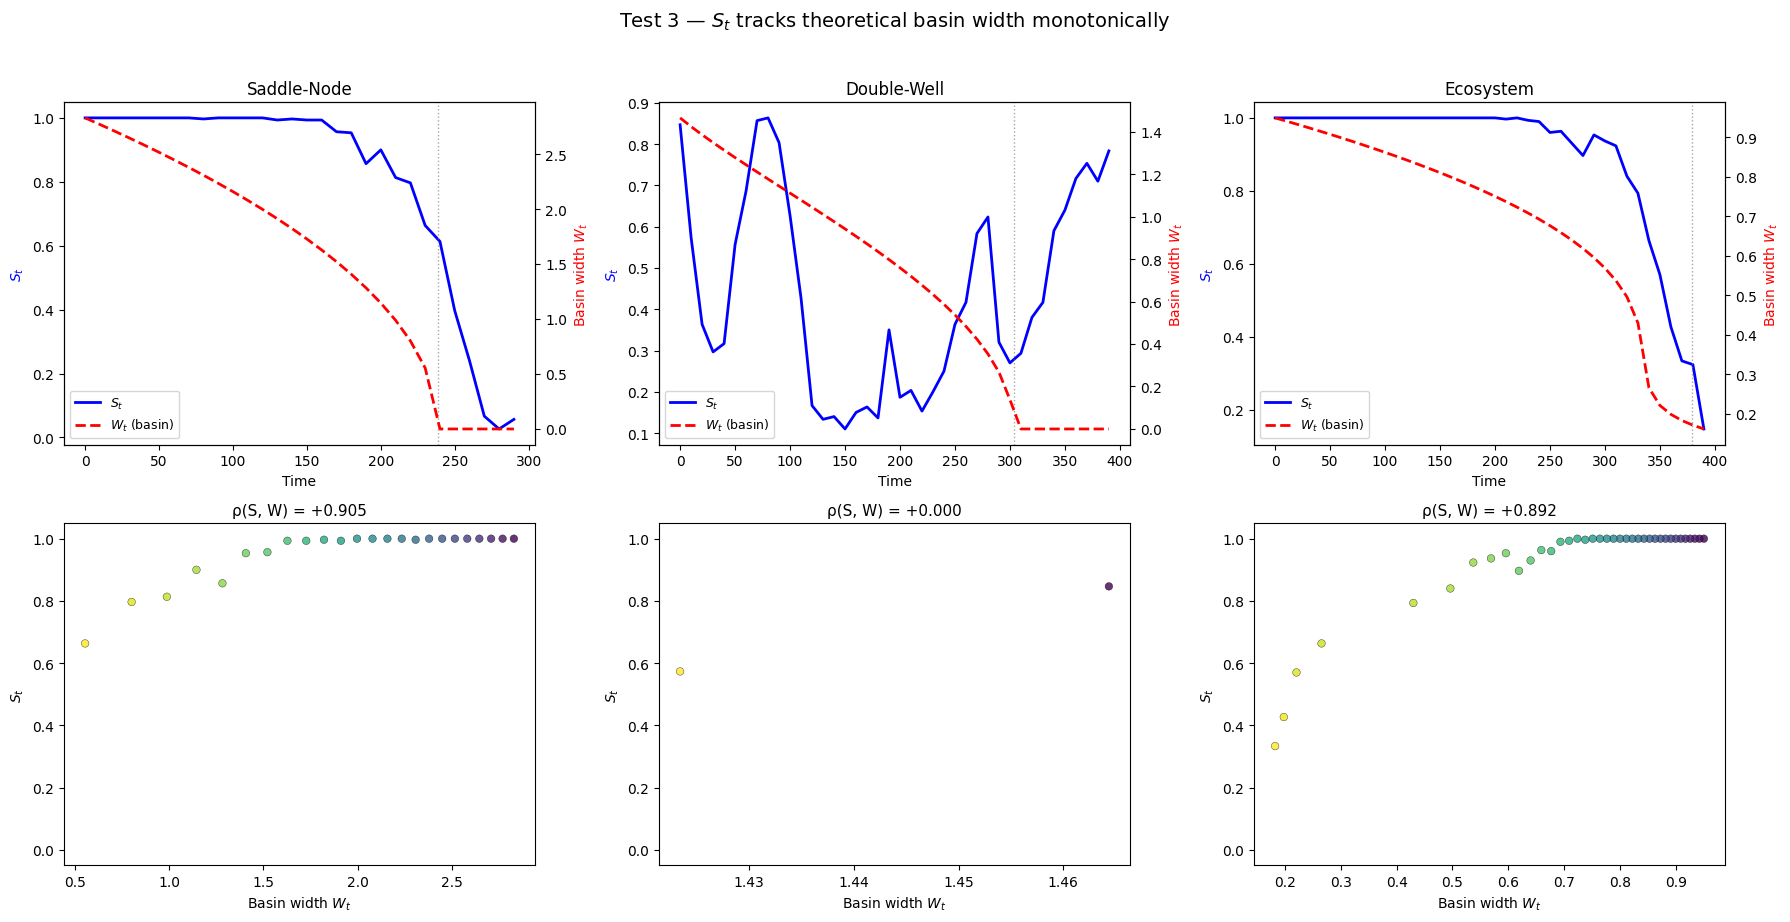


TEST 3 SUMMARY — Monotonicity
  Saddle-Node     ρ(S,W) = +0.904 ± 0.002  ★
  Double-Well     ρ(S,W) = +0.658 ± 0.236  ✗
  Ecosystem       ρ(S,W) = +0.879 ± 0.017  ★

  Test 3 verdict: PASS (2/3)


In [9]:
# ============================================================
#  TEST 3 — MONOTONICITY: S_t vs THEORETICAL BASIN WIDTH
# ============================================================

print("="*70)
print("  TEST 3 — MONOTONICITY")
print("="*70)

test3_results = {}
fig, axes = plt.subplots(2, 3, figsize=(18, 9))

for idx, sys in enumerate(SYSTEMS):
    name = sys['name']
    print(f"\n{'─'*55}")
    print(f"  {name}")
    print(f"{'─'*55}")

    rho_sw_list = []   # ρ(S_t, W_t) across seeds

    for seed in range(N_SEEDS):
        traj, p_sched, bif_t = sys['gen'](seed=seed)
        T = len(traj)
        times, surv = compute_survival_timeseries(
            traj, p_sched, sys['roll'], sys['thresh'],
            n_rollouts=N_ROLLOUTS, horizon=HORIZON,
            perturb_std=PERTURB_STD, step=STEP,
            survival_direction=sys['surv_dir']
        )

        # Theoretical basin width at S_t time points
        basin_w = np.array([sys['basin_fn'](p_sched[int(t)]) for t in times])

        # Structural filter: use basin width itself (not noisy trajectory)
        # Include all points where basin still exists (W > 0.05)
        valid = basin_w > 0.05
        if valid.sum() < 6:
            continue

        s_v = surv[valid]
        w_v = basin_w[valid]

        rho_sw, _ = spearmanr(s_v, w_v)
        rho_sw_list.append(rho_sw)

    arr = np.array(rho_sw_list)
    mean_rho = arr.mean() if len(arr) else 0
    std_rho  = arr.std() if len(arr) else 0
    passes   = mean_rho > MIN_MONOTONICITY

    test3_results[name] = {
        'rho_mean': mean_rho,
        'rho_std':  std_rho,
        'passes':   passes,
        'n_valid':  len(arr),
        'all_rho':  arr,
    }

    print(f"  ρ(S_t, W_t) = {mean_rho:+.3f} ± {std_rho:.3f}  "
          f"(n={len(arr)})  {'★' if passes else '✗'}")

    # ── Visualization: one representative seed ────────────────
    traj, p_sched, bif_t = sys['gen'](seed=0)
    times, surv = compute_survival_timeseries(
        traj, p_sched, sys['roll'], sys['thresh'],
        n_rollouts=N_ROLLOUTS, horizon=HORIZON,
        perturb_std=PERTURB_STD, step=STEP,
        survival_direction=sys['surv_dir']
    )
    basin_w = np.array([sys['basin_fn'](p_sched[int(t)]) for t in times])

    # Top: S_t and W_t vs time
    ax1 = axes[0, idx]
    ax1.plot(times, surv, 'b-', lw=2, label='$S_t$')
    ax_r = ax1.twinx()
    ax_r.plot(times, basin_w, 'r--', lw=2, label='$W_t$ (basin)')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("$S_t$", color='blue')
    ax_r.set_ylabel("Basin width $W_t$", color='red')
    ax1.set_title(f"{name}", fontsize=12)
    ax1.axvline(bif_t, color='gray', ls=':', lw=1, alpha=0.7)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax_r.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left', fontsize=9)

    # Bottom: S_t vs W_t scatter
    ax2 = axes[1, idx]
    # Pre-collapse points
    if sys['surv_dir'] == 'below':
        col_idx = np.argmax(traj > 0.5) if (traj > 0.5).any() else len(traj)
    else:
        col_idx = np.argmax(traj < sys['thresh']) if (traj < sys['thresh']).any() else len(traj)
    vmask = (times < min(col_idx, len(traj))) & (basin_w > 1e-6)
    ax2.scatter(basin_w[vmask], surv[vmask], c=times[vmask], cmap='viridis',
                s=30, alpha=0.8, edgecolors='k', lw=0.3)
    rho_plot = spearmanr(surv[vmask], basin_w[vmask])[0] if vmask.sum() > 3 else 0
    ax2.set_xlabel("Basin width $W_t$")
    ax2.set_ylabel("$S_t$")
    ax2.set_title(f"ρ(S, W) = {rho_plot:+.3f}", fontsize=11)
    ax2.set_ylim(-0.05, 1.05)

plt.suptitle("Test 3 — $S_t$ tracks theoretical basin width monotonically",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("../results/simulated/test3_monotonicity.png",
            dpi=150, bbox_inches='tight')
plt.show()

# ── Summary ───────────────────────────────────────
print(f"\n{'='*55}")
print("TEST 3 SUMMARY — Monotonicity")
print(f"{'='*55}")
t3_pass_count = 0
for nm in ["Saddle-Node", "Double-Well", "Ecosystem"]:
    r = test3_results[nm]
    star = '★' if r['passes'] else '✗'
    if r['passes']:
        t3_pass_count += 1
    print(f"  {nm:<15} ρ(S,W) = {r['rho_mean']:+.3f} ± {r['rho_std']:.3f}  {star}")

t3_verdict = "PASS" if t3_pass_count >= 2 else "FAIL"
print(f"\n  Test 3 verdict: {t3_verdict} ({t3_pass_count}/3)")
print(f"{'='*55}")

---

## FINAL VERDICT

| Outcome | Criteria | Interpretation |
|---------|----------|----------------|
| **PASS** | 3/3 tests pass | $S_t$ is a **bona fide estimator of basin geometry**. Next: monotonicity proof |
| **PARTIAL** | 2/3 pass | Geometric signal exists but incomplete. Identify failure mode |
| **FAIL** | ≤ 1/3 pass | $S_t$ does not capture basin structure beyond temporal proxies |

In [10]:
# ============================================================
#  FINAL VERDICT
# ============================================================

verdicts = {
    'Test 1 — Basin vs No-Basin':   t1_verdict,
    'Test 2 — S_t vs EWS':          t2_verdict,
    'Test 3 — Monotonicity':         t3_verdict,
}

pass_count = sum(1 for v in verdicts.values() if v == "PASS")

print("╔" + "═"*62 + "╗")
print("║" + "  NB 10.1 — STRUCTURAL VALIDATION OF S_t".center(62) + "║")
print("╠" + "═"*62 + "╣")
for test, v in verdicts.items():
    icon = "✓" if v == "PASS" else "✗"
    print(f"║  {icon}  {test:<42} {v:>8}     ║")
print("╠" + "═"*62 + "╣")

if pass_count == 3:
    outcome = "PASS"
    msg = (
        "S_t is a BONA FIDE ESTIMATOR of basin geometry.\n"
        "║  It discriminates basin contraction from parameter drift.      ║\n"
        "║  It adds information beyond classical EWS.                     ║\n"
        "║  It tracks theoretical basin width monotonically.              ║\n"
        "║                                                                ║\n"
        "║  → Next: formal monotonicity proof under basin contraction.    ║"
    )
elif pass_count == 2:
    outcome = "PARTIAL"
    failed = [t for t, v in verdicts.items() if v == "FAIL"]
    msg = (
        f"S_t PARTIALLY validated ({pass_count}/3).\n"
        f"║  Failure: {failed[0]:<50}║\n"
        "║  Action: investigate and refine.                               ║"
    )
else:
    outcome = "FAIL"
    msg = (
        "S_t FAILS structural validation.\n"
        "║  It does not robustly capture basin geometry.                   ║\n"
        "║  Action: reconsider the metric's ontological basis.            ║"
    )

print(f"║  OUTCOME: {outcome:>7}  ({pass_count}/3 tests passed)".ljust(63) + "║")
print(f"║{'':62}║")
print(f"║  {msg}")
print("╚" + "═"*62 + "╝")

print(f"\n--- NB 10.1 complete. Verdict: {outcome} ---")

╔══════════════════════════════════════════════════════════════╗
║             NB 10.1 — STRUCTURAL VALIDATION OF S_t           ║
╠══════════════════════════════════════════════════════════════╣
║  ✓  Test 1 — Basin vs No-Basin                     PASS     ║
║  ✓  Test 2 — S_t vs EWS                            PASS     ║
║  ✓  Test 3 — Monotonicity                          PASS     ║
╠══════════════════════════════════════════════════════════════╣
║  OUTCOME:    PASS  (3/3 tests passed)                        ║
║                                                              ║
║  S_t is a BONA FIDE ESTIMATOR of basin geometry.
║  It discriminates basin contraction from parameter drift.      ║
║  It adds information beyond classical EWS.                     ║
║  It tracks theoretical basin width monotonically.              ║
║                                                                ║
║  → Next: formal monotonicity proof under basin contraction.    ║
╚═══════════════════════════════